In [2]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# Read EDF+ file
def read_edf_file(file_path):
    # Read the EDF+ file
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Get annotations/markers
    annotations = raw.annotations
    print(annotations)
    
    # Convert annotations to DataFrame
    markers_df = pd.DataFrame({
        'Onset': annotations.onset,
        'Duration': annotations.duration,
        'Description': annotations.description
    })
    
    # Get signal data
    data = raw.get_data()    
    return data, markers_df, raw.info['sfreq']

# Write markers to file
def write_markers(markers_df, output_file):
    markers_df.to_csv(output_file, index=False)


def create_intervals(df):
    intervals = {'ds': [], 'is': [], 'swd': []}
    
    # Initialize variables to track start times
    current_starts = {'ds': None, 'is': None, 'swd': None}
    
    # Iterate through the dataframe rows
    for index, row in df.iterrows():
        event_type = row['Description'][:-1]  # Remove the last character (1 or 2)
        event_number = int(row['Description'][-1])  # Get the last character as number
        
        if event_type in ['ds', 'is', 'swd']:
            if event_number == 1:  # Start of interval
                current_starts[event_type] = row['Onset']
            elif event_number == 2:  # End of interval
                if current_starts[event_type] is not None:
                    intervals[event_type].append((current_starts[event_type], row['Onset']))
                    current_starts[event_type] = None
    
    return intervals


# Function to merge overlapping intervals
def merge_intervals(intervals):
    merged = []
    for interval in intervals:
        if not merged:
            merged.append(interval)
        else:
            prev = merged[-1]
            if interval[0] <= prev[1]:
                merged[-1] = (prev[0], max(prev[1], interval[1]))
            else:
                merged.append(interval)
    return merged


# Compute complement intervals for 'normal' class
def compute_complement_intervals(intervals, total_duration):
    complement = []
    prev_end = 0
    for start, end in intervals:
        if start > prev_end:
            complement.append((prev_end, start))
        prev_end = end
    if prev_end < total_duration:
        complement.append((prev_end, total_duration))
    return complement

In [3]:
import os

only_files = [f for f in os.listdir('full_data/') if ".edf" in f.lower()]
only_files

['Ati4x1_15m_BL_6h_edited.edf',
 'Ati4x1_15m_BL_6h_fully_marked.edf',
 'Ati4x1_15m_Dex003(Pharm!)_6h_fully_marked.edf',
 'Ati4x1_15m_H2O_6h_edited.edf',
 'Ati4x1_15m_H2O_6h_fully_marked.edf',
 'Ati4x3B_15m_H2O_6h_edited.edf',
 'Ati4x3_12m_BL_6h_edited.edf',
 'Ati4x3_12m_BL_6h_fully_marked.edf',
 'Ati4x3_9m_Xyl01(Pharm!)_6h_fully_marked.edf',
 'Ati4x6_14m_BL_6h_edited.edf',
 'Ati4x6_14m_BL_6h_fully_marked.edf',
 'Ati4x6_14m_H2O_6h_edited.edf',
 'Ati4x7_14m_BL_6h_edited.edf',
 'Ati4y2_11m_BL_6h_edited.edf',
 'Ati4y3_12m_BL_6h_edited.edf',
 'Ati4y4_12m_BL_6h_edited.edf',
 'Ati4y4_13m_BL_6h_edited.edf',
 'Ati5x1_10m_BL_6h_edited.edf',
 'Ati5x1_11m_BL_6h_edited.edf',
 'Ati5x2_12m_BL_6h_edited.edf',
 'Ati5x3_14m_BL_6h_edited.edf']

In [5]:
# Assuming 'data' is your numpy array of shape (3, 400 * seconds)
# For the sake of example, let's define seconds and sampling rate
seconds = 21600
sampling_rate = 400  # Hz
total_samples = seconds * sampling_rate
channels = 3  # Number of channels in data
window_duration = 2  # seconds
window_size = int(window_duration * sampling_rate)  # Number of samples in a window
full_measurements = []
full_labels = []

for file in only_files:
    data, markers, fs = read_edf_file(os.path.join('full_data/',file))
    intervals = create_intervals(markers)
    print(intervals)

    # Collect all intervals from 'ds', 'is', 'swd'
    all_intervals = []
    for class_name in ['ds', 'is', 'swd']:
        all_intervals.extend(intervals[class_name])
    
    # Sort intervals by start time
    all_intervals.sort(key=lambda x: x[0])
    
    
    merged_intervals = merge_intervals(all_intervals)
    
    
    total_time = seconds  # Total measurement duration
    normal_intervals = compute_complement_intervals(merged_intervals, total_time)
    intervals['normal'] = normal_intervals

    measurements = {}
    labels = []
    labels_present = []
    
    for class_name in ['ds', 'is', 'swd', 'normal']:
        indices_list = []
        for start_time, end_time in intervals[class_name]:
            min_idx = int(np.ceil(start_time * sampling_rate))
            max_idx = int(np.floor(end_time * sampling_rate) - window_size + 1)
            if max_idx >= min_idx:
                indices = np.arange(min_idx, max_idx + 1)
                indices_list.append(indices)
        if indices_list:
            all_indices = np.concatenate(indices_list)
            # Sample 2000 indices
            if len(all_indices) >= 2000:
                sampled_indices = np.random.choice(all_indices, 2000, replace=False)
            else:
                sampled_indices = all_indices
                print('OVERSAMPLED')
                print(len(all_indices))
                print('OVERSAMPLED')
            # Extract measurements
            class_measurements = np.array([
                data[:, idx:idx + window_size] for idx in sampled_indices
            ])
            measurements[class_name] = class_measurements
            labels.extend([class_name] * len(sampled_indices))
            labels_present.append(class_name)
        else:
            print(f"No valid measurements found for class {class_name}")
        # Combine datafrom all classes
    all_measurements = np.concatenate([measurements[class_name] for class_name in labels_present], axis=0)
    # Convert labels to numeric classes if needed
    label_map = {'ds': 0, 'is': 1, 'swd': 2, 'normal': 3}
    numeric_labels = np.array([label_map[label] for label in labels])

    full_measurements.extend(all_measurements)
    full_labels.extend(numeric_labels)

Extracting EDF parameters from /media/kglin/NewData/Hack-ECG/full_data/Ati4x1_15m_BL_6h_edited.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8640399  =      0.000 ... 21600.998 secs...
<Annotations | 12 segments: ds1 (3), ds2 (3), is1 (3), is2 (3)>
{'ds': [(223.725, 261.9375), (1722.675, 1771.9875), (7459.225, 7516.7125)], 'is': [(1772.3, 1790.55), (7813.406493, 7828.546472), (9128.025, 9161.1125)], 'swd': []}
No valid measurements found for class swd
Extracting EDF parameters from /media/kglin/NewData/Hack-ECG/full_data/Ati4x1_15m_BL_6h_fully_marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8640399  =      0.000 ... 21600.998 secs...
<Annotations | 138 segments: ds1 (57), ds2 (57), is1 (12), is2 (12)>
{'ds': [(178.0, 262.0), (343.0, 496.0), (1475.0, 1501.0), (1511.0, 1772.0), (2003.0, 2246.0), (2255.0, 2288.0), (2317.0, 2356.0), (2437.0, 2519.0), (2581.0, 2636.0), (2

In [6]:
len(full_labels)

132000

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import AUROC, Accuracy
from pytorch_lightning.loggers import TensorBoardLogger

# 1. Scaling the data
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        # data: numpy array of shape (N_samples, 3, 800)
        self.data = torch.tensor(data, dtype=torch.float32)  # Shape: (N_samples, 3, 800)
        self.labels = torch.tensor(labels, dtype=torch.long)

        # Standardize the data
        self.data = (self.data - self.data.mean()) / self.data.std()
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Example usage:
dataset = EEGDataset(np.array(full_measurements), np.array(full_labels))
len(dataset)

638256

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import AUROC, Accuracy, F1Score
from pytorch_lightning.loggers import TensorBoardLogger

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class EEGClassifier(pl.LightningModule):
    def __init__(self, num_classes=4, learning_rate=1e-3):
        super().__init__()
        
        # Network Architecture
        self.conv1 = nn.Conv1d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(64, 64, 3, stride=1)
        self.layer2 = self._make_layer(64, 64, 3, stride=2)
        self.layer3 = self._make_layer(64, 64, 3, stride=2)
        self.layer4 = self._make_layer(64, 64, 3, stride=2)
        self.layer5 = self._make_layer(64, 64, 3, stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
        # Metrics
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes)

        self.val_auroc = AUROC(task="multiclass", num_classes=num_classes)
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        
        # Initialize list to store validation outputs
        self.validation_step_outputs = []

        self.class_weights = torch.tensor([
            4.0,    # class 0
            4.0,    # class 1
            4.0,    # class 2
            1.0,     # class 3 (normal) - lower weight since it's more frequent
        ])

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # ResNet blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        # Global average pooling and classification
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_accuracy"
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        class_weights = self.class_weights.to(self.device)
        
        # Use weighted cross entropy loss
        loss = F.cross_entropy(logits, y, weight=class_weights)        
        # Calculate and log accuracy
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, y)
        f1 = self.val_f1(preds,y)
        
        # Logging
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_f1',f1,prog_bar = True)
        self.log('train_accuracy', acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        class_weights = self.class_weights.to(self.device)
        
        # Use weighted cross entropy loss
        loss = F.cross_entropy(logits, y, weight=class_weights)        
        # Calculate metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, y)
        f1 = self.val_f1(preds, y)

        auroc = self.val_auroc(F.softmax(logits, dim=1), y)
        
        # Logging
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)
        self.log('val_auroc', auroc, prog_bar=True)
        
        # Store output for epoch end processing
        self.validation_step_outputs.append(loss)
        
        return loss

    def on_validation_epoch_end(self):
        # Compute epoch-level metrics
        avg_loss = torch.stack(self.validation_step_outputs).mean()
        
        # Log epoch-level metrics
        self.log('val_epoch_loss', avg_loss)
        self.log('val_epoch_accuracy', self.val_accuracy.compute())
        self.log('val_epoch_auroc', self.val_auroc.compute())
        
        # Clear the list for the next epoch
        self.validation_step_outputs.clear()

    def on_train_epoch_end(self):
        # Log epoch-level training metrics
        self.log('train_epoch_accuracy', self.train_accuracy.compute())

    def get_all_predictions(self, dataloader):
        self.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in dataloader:
                x, y = batch
                logits = self(x)
                preds = torch.argmax(logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        
        return np.array(all_preds), np.array(all_labels)
    

In [11]:
    batch_size=512
    torch.set_float32_matmul_precision('medium')
    max_epochs=30
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4
    )

    # Initialize model and trainer
    model = EEGClassifier()
    logger = TensorBoardLogger("lightning_logs", name="eeg_tcn")
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        logger=logger,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[
            pl.callbacks.ModelCheckpoint(
                monitor='val_accuracy',
                mode='max',
                save_top_k=3,
                filename='{epoch}-{val_accuracy:.2f}'
            ),
            pl.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                mode='max'
            )
        ]
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv1d             | 1.3 K 
1  | bn1            | BatchNorm1d        | 128   
2  | pool           | MaxPool1d          | 0     
3  | layer1         | Sequential         | 74.5 K
4  | layer2         | Sequential         | 78.7 K
5  | layer3         | Sequential         | 78.7 K
6  | layer4         | Sequential         | 78.7 K
7  | layer5         | Sequential         | 78.7 K
8  | avgpool        | AdaptiveAvgPool1d  | 0     
9  | fc             | Linear             | 260   
10 | dropout        | Dropout            | 0     
11 | train_accuracy | MulticlassAccuracy | 0     
12 | val_accuracy   | MulticlassAccuracy | 0     
13 | val_f1         | MulticlassF1Score  | 0     

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [13]:
model.cpu()
a = model.get_all_predictions(val_loader)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(a[0], a[1])



In [15]:
cm

array([[41146,     1,     0,  5346],
       [    9, 15680,     0,   160],
       [    2,     3, 27828,   336],
       [  932,     6,    33, 36170]])

NameError: name 'reverse_label_map' is not defined

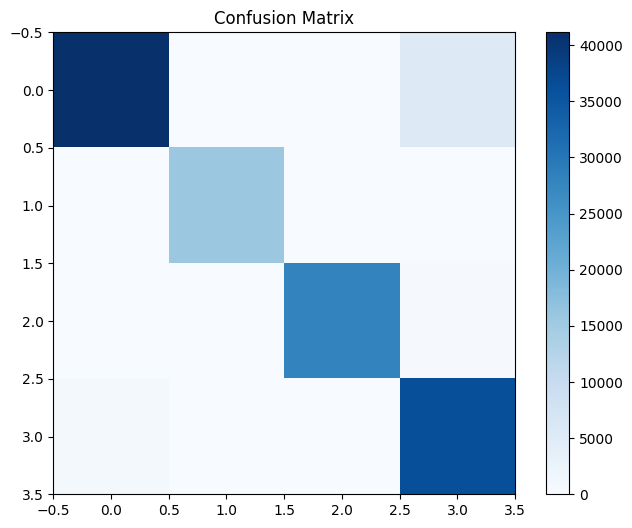

In [16]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Use the custom class names
class_names = [reverse_label_map[i] for i in range(len(label_map))]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [17]:
import torch
import numpy as np

def predict(model, numpy_array):
    # Make sure the model is in evaluation mode
    model.eval()
    
    # Convert numpy array to PyTorch tensor
    # Assuming your input shape is (samples, channels, sequence_length)
    # If not, you might need to reshape your numpy array first
    tensor_data = torch.FloatTensor(numpy_array)
    
    # If you have a GPU and want to use it
    if torch.cuda.is_available():
        tensor_data = tensor_data.cuda()
        model = model.cuda()
    
    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        logits = model(tensor_data)
        probabilities = torch.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
    
    # Convert back to numpy
    predictions = predictions.cpu().numpy()
    probabilities = probabilities.cpu().numpy()
    
    return predictions, probabilities

# Example usage:
# Assuming your numpy array has shape (batch_size, 3, sequence_length)
# where 3 is the number of channels as defined in your model
numpy_data = np.random.rand(10, 3, 800)  # Example data
predictions, probabilities = predict(model, numpy_data)

# predictions will contain the predicted class labels
# probabilities will contain the probability distribution over all classes


In [27]:
inference_data, inference_markers, fs = read_edf_file('to-classify/TEST1_30min.edf')
inference_data = inference_data[:,:]

Extracting EDF parameters from /media/kglin/NewData/Hack-ECG/to-classify/TEST1_30min.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 719999  =      0.000 ...  1799.997 secs...
<Annotations | 0 segments>


In [35]:
inference_data

array([[-3.450000e-05,  2.506250e-05, -1.068750e-05, ...,  8.268750e-05,
         4.637500e-05,  1.875000e-06],
       [-2.040625e-04, -1.804375e-04, -1.986875e-04, ..., -4.000000e-05,
        -9.318750e-05, -1.441250e-04],
       [-4.237500e-05, -2.793750e-05, -2.993750e-05, ...,  9.212500e-05,
         8.912500e-05,  1.125625e-04]])

In [28]:
inference_batch = ((inference_data - np.array(full_measurements).mean())/np.array(full_measurements).std()).reshape(3,-1,800).transpose(1,0,2)
inference_batch

array([[[-0.25842242,  0.13045934, -0.10295133, ..., -0.42083054,
         -0.36900684, -0.11764151],
        [-1.36549084, -1.21124393, -1.33039763, ...,  0.13209158,
         -0.12661884,  0.02232328],
        [-0.30983806, -0.21557606, -0.228634  , ..., -0.22781787,
         -0.20537454, -0.15436697]],

       [[ 0.08598073,  0.03578928,  0.06476158, ...,  0.09536613,
          0.14106891,  0.52995067],
        [ 0.13535606, -0.00297648,  0.21125534, ..., -0.95008515,
         -0.82113799, -0.11192866],
        [-0.12784303, -0.18537957,  0.17820243, ..., -0.07357097,
          0.24716467,  0.37039897]],

       [[ 0.74418249,  0.68215728,  0.90781479, ...,  0.21043922,
          0.36509419, -0.06785812],
        [ 0.04680691, -0.30983806, -0.36206981, ..., -0.33350557,
         -0.46979781, -0.84684581],
        [ 0.00640891, -0.05194375,  0.19493291, ...,  0.8580314 ,
          0.95882237,  0.2406357 ]],

       ...,

       [[ 0.18636364,  0.2675677 ,  0.17616213, ...,  0.4618045

In [29]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

def predict_with_batching(model, numpy_array, batch_size=32):
    """
    Make predictions on data with batching.
    
    Args:
        model: PyTorch model
        numpy_array: Input numpy array
        batch_size: Size of batches to process at once
    
    Returns:
        predictions: Numpy array of predicted classes
        probabilities: Numpy array of class probabilities
    """
    # Make sure the model is in evaluation mode
    model.eval()
    
    # Convert numpy array to PyTorch tensor
    tensor_data = torch.FloatTensor(numpy_array)
    
    # Create dataset and dataloader
    dataset = TensorDataset(tensor_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Lists to store predictions and probabilities
    all_predictions = []
    all_probabilities = []
    
    # Perform predictions in batches
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            batch = batch[0].to(device)
            
            # Make prediction
            logits = model(batch)
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            # Store results
            all_predictions.append(predictions.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())
    
    # Concatenate all batches
    predictions = np.concatenate(all_predictions)
    probabilities = np.concatenate(all_probabilities)
    
    return predictions, probabilities


    
    # Define batch size
inference_batch_size = 32

predictions, probabilities = predict_with_batching(model, inference_batch, inference_batch_size)
        
print(f"Predictions shape: {predictions.shape}")
print(f"Probabilities shape: {probabilities.shape}")
        


Predictions shape: (900,)
Probabilities shape: (900, 4)


In [30]:
Counter(predictions)

Counter({3: 752, 0: 144, 1: 4})

In [1]:

np.save("preds_1",predictions)

NameError: name 'np' is not defined

In [24]:
inference_markers

,Onset,Duration,Description


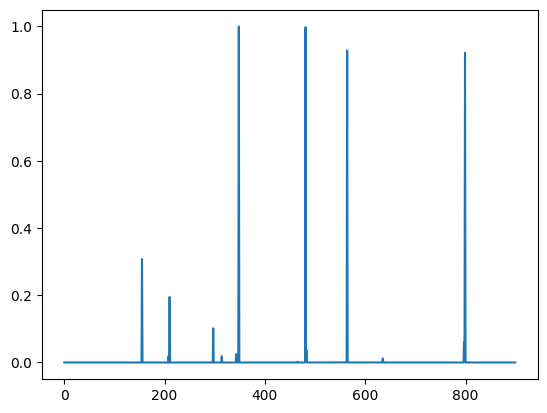

In [37]:
plt.plot(probabilities[:,1])

In [7]:
import fcwt
import numpy as np
import matplotlib.pyplot as plt

#Initialize
fs = 400

f0 = 1#lowest frequency
f1 = 21 #highest frequency
fn = 50 #number of frequencies

#... or calculate and plot CWT
fcwt.plot(inference_data[0,:2000], fs, f0=f0, f1=f1, fn=fn)

NameError: name 'inference_data' is not defined